# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import time, itertools

num_iters = 1500
tic = time.time()

def train_validate_svm(learning_rate, reg):
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                          num_iters=num_iters, verbose=True)
    y_train_pred = np.mean(y_train == svm.predict(X_train_feats))
    y_val_pred = np.mean(y_val == svm.predict(X_val_feats))
    return (y_train_pred, y_val_pred, svm)

combinations = itertools.product(*[learning_rates, regularization_strengths])
full_results = {(lr, reg): (train_validate_svm(lr, reg)) for lr, reg in combinations}
sorted_by_validation_error = sorted(full_results.values(), key=lambda tup: tup[1])
_, best_val, best_svm = sorted_by_validation_error[-1]

results = {x: (y, z) for x, (y, z, _) in full_results.items()}

toc = time.time()
print('That took %fs' % (toc - tic))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 84.877459
iteration 100 / 1500: loss 83.376940
iteration 200 / 1500: loss 81.896731
iteration 300 / 1500: loss 80.453944
iteration 400 / 1500: loss 79.044726
iteration 500 / 1500: loss 77.668498
iteration 600 / 1500: loss 76.295166
iteration 700 / 1500: loss 74.954286
iteration 800 / 1500: loss 73.656761
iteration 900 / 1500: loss 72.368634
iteration 1000 / 1500: loss 71.124407
iteration 1100 / 1500: loss 69.888413
iteration 1200 / 1500: loss 68.699952
iteration 1300 / 1500: loss 67.505589
iteration 1400 / 1500: loss 66.329200
iteration 0 / 1500: loss 796.564320
iteration 100 / 1500: loss 653.756124
iteration 200 / 1500: loss 536.817343
iteration 300 / 1500: loss 441.099921
iteration 400 / 1500: loss 362.736126
iteration 500 / 1500: loss 298.593089
iteration 600 / 1500: loss 246.073522
iteration 700 / 1500: loss 203.084764
iteration 800 / 1500: loss 167.877890
iteration 900 / 1500: loss 139.073923
iteration 1000 / 1500: loss 115.483207
iteration 1100 / 1500: lo

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


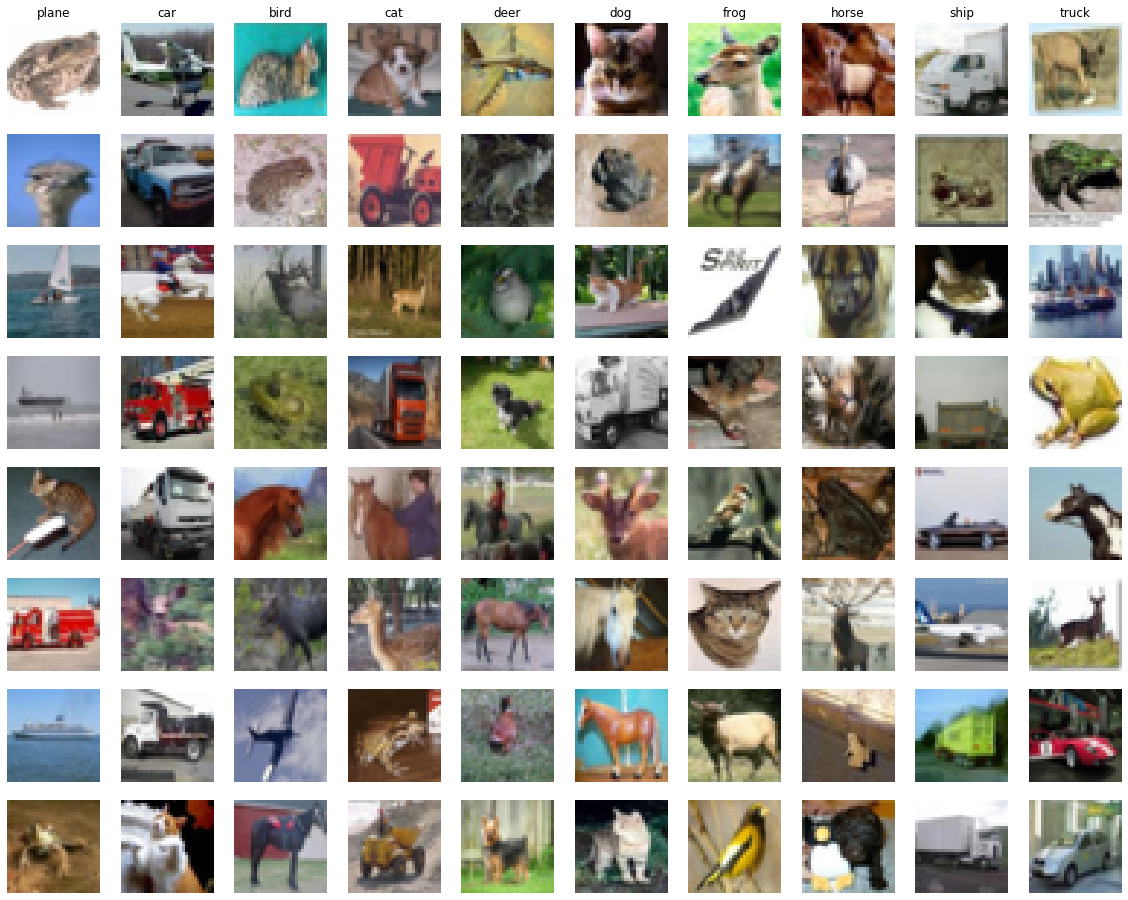

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

$\color{blue}{\textit Your Answer:}$ The HOG generally speaking computes gradients at a larger scale that won't allow us to see very fine grained features like fur, etc. The mistakes seem to reflect that this information is missing.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


Hyperparameters(learning_rate=0.2, regularization_strength=0.0, batch_size=250, training_epochs=10, hidden_size=4000)
154
1960
iteration 0 / 1960: loss 2.302586
iteration 100 / 1960: loss 1.994342
iteration 200 / 1960: loss 1.640310
iteration 300 / 1960: loss 1.295487
iteration 400 / 1960: loss 1.408950
iteration 500 / 1960: loss 1.336743
iteration 600 / 1960: loss 1.238631
iteration 700 / 1960: loss 1.268858
iteration 800 / 1960: loss 1.282405
iteration 900 / 1960: loss 1.239292
iteration 1000 / 1960: loss 1.194903
iteration 1100 / 1960: loss 1.150859
iteration 1200 / 1960: loss 1.229720
iteration 1300 / 1960: loss 1.160703
iteration 1400 / 1960: loss 1.079065
iteration 1500 / 1960: loss 1.181049
iteration 1600 / 1960: loss 1.095601
iteration 1700 / 1960: loss 1.101229
iteration 1800 / 1960: loss 1.033591
iteration 1900 / 1960: loss 0.947980


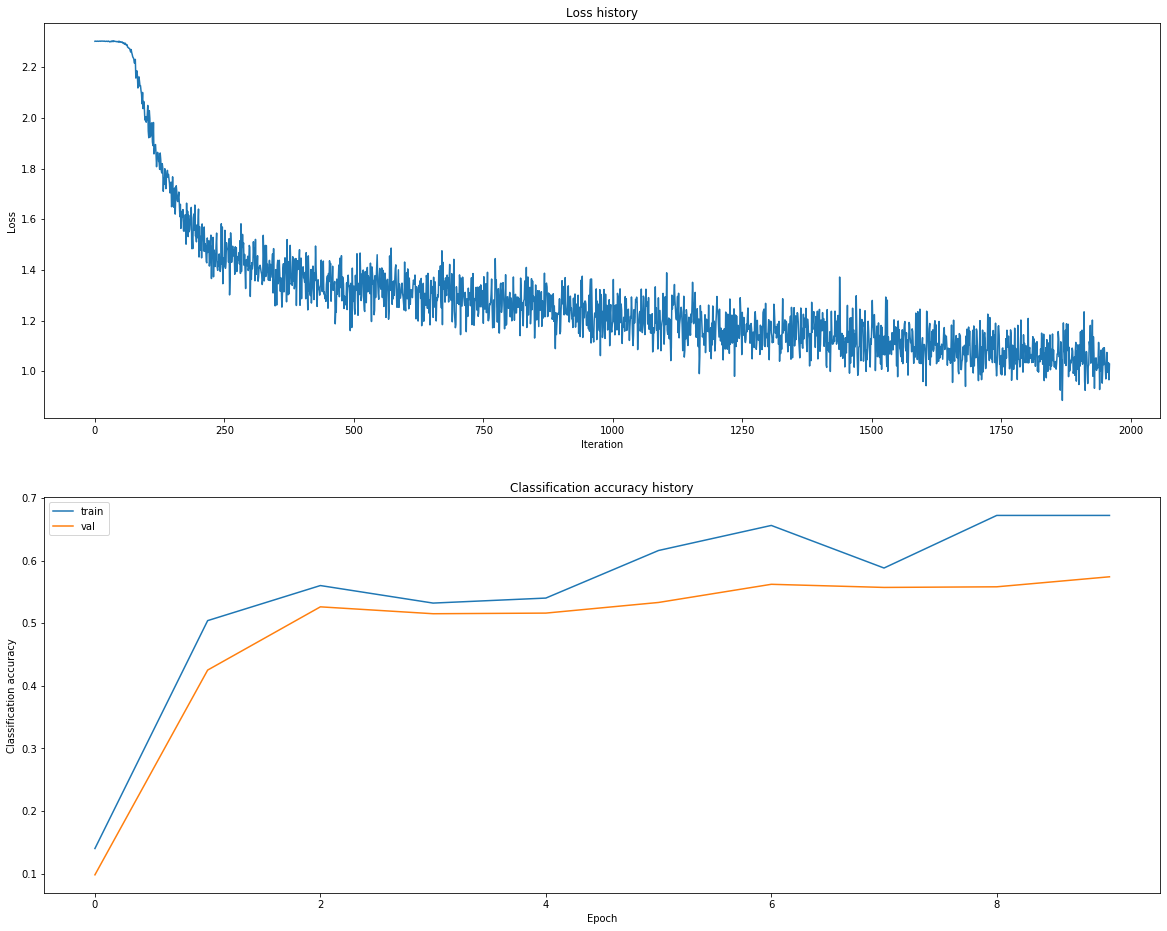

lr 2.000000e-01 reg 0.000000e+00 train accuracy: 0.672000 val accuracy: 0.574000


In [42]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def plot_loss_history(stats):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

import itertools
from collections import namedtuple

Hyperparameters = namedtuple('Hyperparameters', [
    'learning_rate',
    'regularization_strength',
    'batch_size',
    'training_epochs',
    'hidden_size'
])
hyperparameter_combinations = []
hyperparameter_combinations.append(Hyperparameters(
    learning_rate=2e-1,
    regularization_strength=0.0,
    batch_size=250,
    training_epochs=10,
    hidden_size=4000
))

def train_validate_two_layer(hyperparameters):
    print(hyperparameters)
    input_size = input_dim
    num_classes = 10
    print(input_size)
    net = TwoLayerNet(input_size, hyperparameters.hidden_size, num_classes)
    
    num_train = X_train_feats.shape[0]
    num_iters = round(
        num_train * hyperparameters.training_epochs / hyperparameters.batch_size
    )
    print(num_iters)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=num_iters, batch_size=hyperparameters.batch_size,
                learning_rate=hyperparameters.learning_rate,
                learning_rate_decay=0.95,
                reg=hyperparameters.regularization_strength, verbose=True)
    
    stats['net'] = net

    return stats

all_results = {hyperparameters: (train_validate_two_layer(hyperparameters)) for hyperparameters in hyperparameter_combinations}
sorted_by_validation_error = sorted(all_results.items(), key=lambda item: item[1]['val_acc_history'][-1])
best_stats = sorted_by_validation_error[-1][1]
plot_loss_history(best_stats)
best_net = best_stats['net']

for hyperparameters, stats in sorted(sorted_by_validation_error):
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        hyperparameters.learning_rate, hyperparameters.regularization_strength, stats['train_acc_history'][-1], stats['val_acc_history'][-1]))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [43]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.559
